# 权重衰退 weight-decay

> 应用最广泛的正则化技术

**处理过拟合的方法**

通过限制参数值的选择范围，控制模型容量，防止过拟合

- 限制抖动，平滑曲线

**均方范数作为硬性限制**

$$min loss(w, b)\quad subject\quad to \quad ||w||_2^2\leq\theta$$

- 不限制偏移 b
- 小的 $\theta\quad 1, 0.1, 0.01$ 意味着更强的正则项

**均方范数柔性限制**

$$min loss(w, b)+\frac{\lambda}{2}||w||_2^2$$

每一个 $\theta$ 均可以找到 $\lambda$ 使得之前的目标函数等价于上述函数

- 可以通过拉格朗日乘子证明
- 超参数 $\lambda$ 控制了正则项的重要程度
    - $\lambda=0$：无作用
    - $\lambda\rightarrow\infty，w\rightarrow 0$

******

**参数更新**：

**梯度的计算**

$$\frac{\partial}{\partial w}(loss(w,b)+\frac{\lambda loss(w,b)}{2}||w||_2^2)=\frac{\partial loss(w,b)}{\partial w}+\lambda w$$

**权重的更新**

$$w_{t+1}=w_t-\eta\frac{\partial}{\partial w}(loss(w,b)+\frac{\lambda loss(w,b)}{\partial w})=(1-\mathbf{\eta\lambda})w_t-\eta\frac{\partial loss(w_t,b_t)}{\partial w_t}\quad \eta\lambda < 1$$

In [1]:
%matplotlib inline
import torch
import numpy as np
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline

In [2]:
""" 数据加载函数 """
def synthetic_data(w, b, num_examples):
    x = torch.normal(mean=0, std=1, size=(num_examples, len(w)))
    y = torch.matmul(x, w) + b
    y += torch.normal(mean=0, std=0.01, size=y.shape)
    return x, y.reshape((-1, 1))

def load_arrays(data_arrays, batch_size, is_train=True):
    return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(*data_arrays), batch_size=batch_size, shuffle=is_train)

$$y=0.05+\sum_{i=1}^d0.01x_i+\epsilon\quad\text{where}\epsilon\sim N(0, 0.01)$$

In [3]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = synthetic_data(true_w, true_b, n_train)
train_iter = load_arrays(train_data, batch_size)
test_data = synthetic_data(true_w, true_b, n_test)
test_iter = load_arrays(test_data, batch_size, is_train=False)

In [4]:
""" 初始化参数模型 """
def init_params():
    w = torch.normal(mean=0, std=1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return w, b

In [5]:
""" 累加器对象 """
class Accumulator: # 累加器对象
    """ 在 n 个变量上累加 """
    def __init__(self, n):
        self.data = [0.0] * n # python 语法 [0]*n将n个list连接在一起

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        # zip() 将迭代器打包成元组

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, index):
        return self.data[index]
        
""" 损失估测 """
def evaluate_loss(net, data_iter, loss):
    """Evaluate the loss of a model on the given dataset.

    Defined in :numref:`sec_model_selection`"""
    metric = Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [6]:
""" L2惩罚 """
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2 # L2 范数的平方

# 定义模型
def linreg(X, w, b):
    return torch.matmul(X, w) + b

# 损失函数
def squred_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2

In [7]:
""" 训练函数 """
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: linreg(X, w, b), squred_loss
    num_epochs, lr = 100, 0.003
    train, test = [], []

    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            sgd([w, b], lr, batch_size)
        if epoch == 0 or (epoch+1) % 10 == 0:
            train.append(evaluate_loss(net, train_iter, loss))
            test.append(evaluate_loss(net, test_iter, loss))
    
    """ 绘图 """
    backend_inline.set_matplotlib_formats('svg')
    plt.rcParams["figure.figsize"] = (3.5, 2.5)
        
    plt.semilogy(list(range(0, num_epochs+1,10)), train, 'm--')
    plt.semilogy(list(range(0, num_epochs+1,10)), test, 'r:')
    plt.legend(["train", "test"])
    plt.xlabel('epochs')
    plt.ylabel('percent')
    plt.grid(True)
    print(torch.norm(w).item())

14.446090698242188


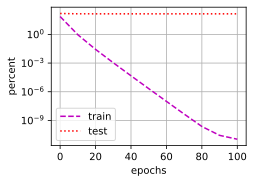

In [8]:
train(lambd=0) # gap 很大

0.39314472675323486


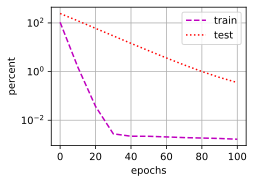

In [9]:
train(lambd=3)

0.028063753619790077


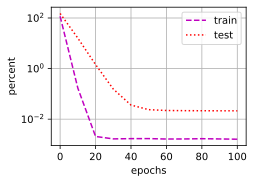

In [10]:
train(10)

In [11]:
def train_concise(wd):
    net = torch.nn.Sequential(torch.nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = torch.nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    test, train = [], []
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
            
        if epoch == 0 or (epoch+1) % 10 == 0:
            train.append(evaluate_loss(net, train_iter, loss))
            test.append(evaluate_loss(net, test_iter, loss))
    
    """ 绘图 """
    backend_inline.set_matplotlib_formats('svg')
    plt.rcParams["figure.figsize"] = (3.5, 2.5)

        
    plt.semilogy(list(range(0, num_epochs+1,10)), train, 'm--')
    plt.semilogy(list(range(0, num_epochs+1,10)), test, 'r:')
    plt.legend(["train", "test"])
    plt.xlabel('epochs')
    plt.ylabel('percent')
    plt.grid(True)
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 12.877615928649902


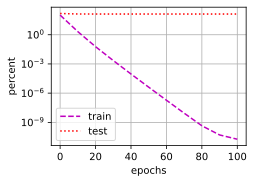

In [12]:
train_concise(0)

w的L2范数： 0.35596340894699097


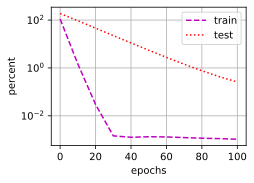

In [13]:
train_concise(3)

w的L2范数： 0.03564300388097763


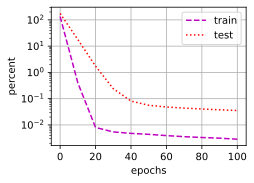

In [14]:
train_concise(10)

- 权重衰退一般取 $10^{-3} / 10^{-4}$
- 权重衰退的作用不是很好